# Final Project
By **Christian Gould, Blake Gebhardt, Caleb Moore**

Dataset: [Link](hello)

In [70]:
# Imports
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import os
import cv2
import matplotlib.pyplot as plt
import PIL.Image as img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split

# Preparation (3 points total)  
>  [1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

<div style="color: green">
Why Confusion Matrix?

* The confusion matrix is a good metric for evaluating the performance of a binary classification model that predicts whether a person has COVID-19 or not, from their images. This is because the confusion matrix provides a detailed breakdown of the model's predictions, which can help us understand how well the model is performing and identify specific areas for improvement.

* For example, let's say we have a dataset of chest X-ray images of people who have been tested for COVID-19. We want to train a binary classifier to predict whether a person has COVID-19 or not, based on their chest X-ray image. In this case, a confusion matrix can provide the following information:

* True Positives (TP): The number of people who have COVID-19 and are correctly identified by the model as having COVID-19.
True Negatives (TN): The number of people who do not have COVID-19 and are correctly identified by the model as not having COVID-19.
False Positives (FP): The number of people who do not have COVID-19 but are incorrectly identified by the model as having COVID-19.
False Negatives (FN): The number of people who have COVID-19 but are incorrectly identified by the model as not having COVID-19.
</div>

> [1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice.

<div style="color: green">
For the task of binary classification to predict COVID-19 based on chest X-ray images,
we will be using stratified k-fold cross-validation to split the data into training and testing
sets. This method ensures that the training and testing sets have a balanced representation of
both classes and allows for robust evaluation of the model's performance. Additionally, a
random train-test split may be used as a supplementary method for comparison, but stratified
k-fold cross-validation should be the primary method. Both methods are realistic reflections 
of how the model would be used in practice.
</div>

# Modeling
> [1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop. You can also use the Keras-cv augmenter (a separate package: https://keras.io/keras_cv/ Links to an external site.)

### Get the data
* The data is originally in a training and testing set when given to us, but we are going to add the data into one big dataset because we want to use k-folds

In [71]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Set the Directories
train_directory = './Covid19-dataset/train/'
test_directory = './Covid19-dataset/test/'

# Create a list of labels for each image
train = []
for folder in os.listdir(train_directory):
    sub_path = train_directory + '/' + folder
    for image in os.listdir(sub_path):
        img_path = sub_path + '/' + image
        img = cv2.imread(img_path)
        img = cv2.resize(img,(224,224)) #VGG19 needs an input of shape 224x224
        train.append(img)

test = []
for folder in os.listdir(test_directory):
    sub_test = test_directory + '/' + folder
    for image in os.listdir(sub_test):
        img_test = sub_test + '/' + image
        imgtest = cv2.imread(img_test)
        imgtest = cv2.resize(imgtest,(224,224))
        test.append(imgtest)

train_labels = []
for folder in os.listdir(train_directory):
    sub_path = train_directory + '/' + folder
    for image in os.listdir(sub_path):
        train_labels.append(folder)

test_labels = []
for folder in os.listdir(test_directory):
    sub_test = test_directory + '/' + folder
    for image in os.listdir(sub_test):
        test_labels.append(folder)


encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(train_labels)
y_test_encoded = encoder.transform(test_labels)

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

y = np.concatenate((y_train_categorical, y_test_categorical), axis=0)


data = np.array(train + test)/255.0

# Combine data and labels into one array
X = data.reshape((-1, 224, 224, 3))

# Initialize k-fold cross-validation
kf = KFold(n_splits=2, shuffle=True, random_state=42)

### Print a few of the images

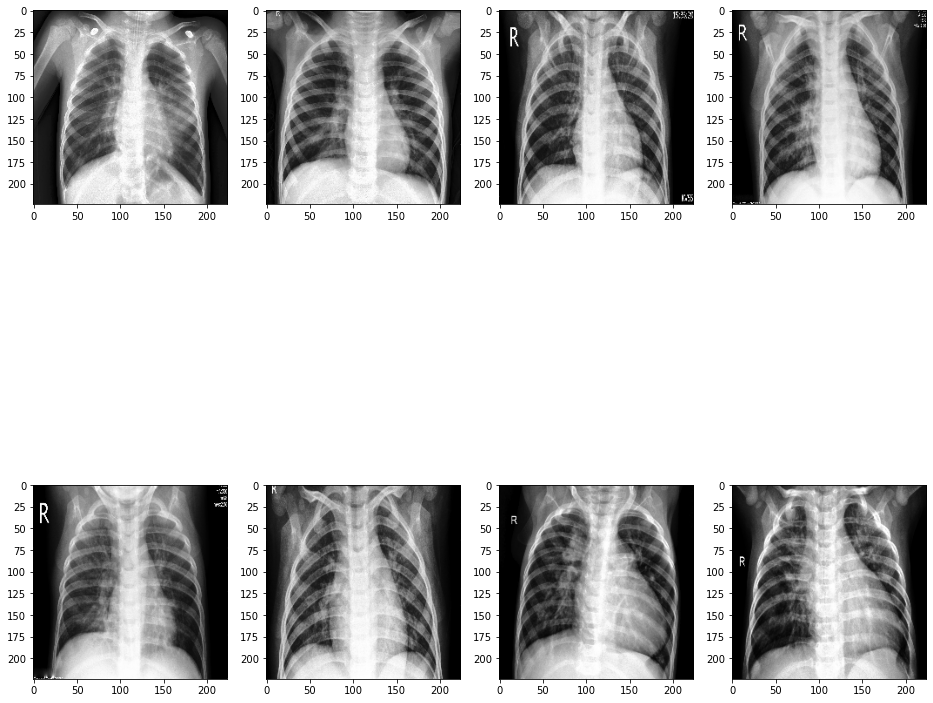

In [72]:
plt.figure(figsize=(16,16))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(X[i])

### Run and make the neural networks

> [2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture such as the number of filters--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

In [73]:
def model_A(variation):
    if variation == 1:
        num_filters = [32, 64]
    elif variation == 2:
        num_filters = [64, 128]
    else:
        raise ValueError("Invalid variation number")

    model = Sequential([
        Conv2D(num_filters[0], kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(num_filters[1], kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Assuming 3 classes
    ])

    return model


In [74]:
def model_B(variation):
    if variation == 1:
        num_filters = [32, 64]
    elif variation == 2:
        num_filters = [64, 128]
    else:
        raise ValueError("Invalid variation number")

    model = Sequential([
        Conv2D(num_filters[0], kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
        Conv2D(num_filters[0], kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(num_filters[1], kernel_size=(3, 3), activation='relu'),
        Conv2D(num_filters[1], kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Assuming 3 classes
    ])

    return model


In [75]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=20):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))
    return history, model

### Run the Model
* We ran one of the models a few times, then saw how many epochs we should use for some efficiency.
* After running this code with run_slow=True, we found that 10 epochs is a good number to use for the rest of the models. The graphs for such are here:

![image.png](./images/model_A_fold_1.png)
![image2.png](./images/model_A_fold_2.png)

* So, we decided to use 10 epochs for the rest of the models.

### _NOTE_
The block below took 15 mins on my computer. You're running a ton of models

Fold Number:  1
Epoch 1/10
5/5 [==============================] - 4s 669ms/step - loss: 3.4782 - accuracy: 0.4114 - val_loss: 1.1020 - val_accuracy: 0.4717
Epoch 2/10
5/5 [==============================] - 3s 629ms/step - loss: 0.8812 - accuracy: 0.5949 - val_loss: 0.6518 - val_accuracy: 0.8176
Epoch 3/10
5/5 [==============================] - 3s 632ms/step - loss: 0.6039 - accuracy: 0.7911 - val_loss: 0.3511 - val_accuracy: 0.8994
Epoch 4/10
5/5 [==============================] - 3s 572ms/step - loss: 0.3863 - accuracy: 0.8291 - val_loss: 0.2844 - val_accuracy: 0.9182
Epoch 5/10
5/5 [==============================] - 3s 577ms/step - loss: 0.2574 - accuracy: 0.8734 - val_loss: 0.2620 - val_accuracy: 0.9371
Epoch 6/10
5/5 [==============================] - 3s 578ms/step - loss: 0.2384 - accuracy: 0.9177 - val_loss: 0.1570 - val_accuracy: 0.9623
Epoch 7/10
5/5 [==============================] - 3s 560ms/step - loss: 0.1404 - accuracy: 0.9620 - val_loss: 0.2056 - val_accuracy: 0.9434
Epoc

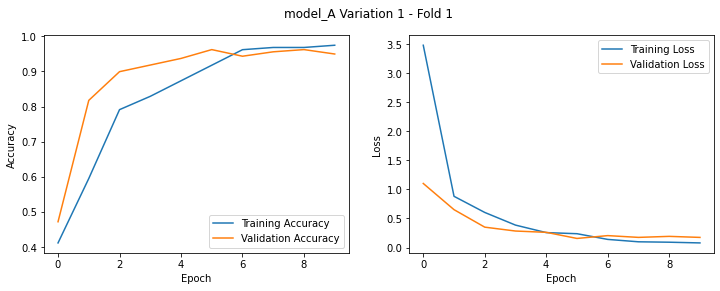

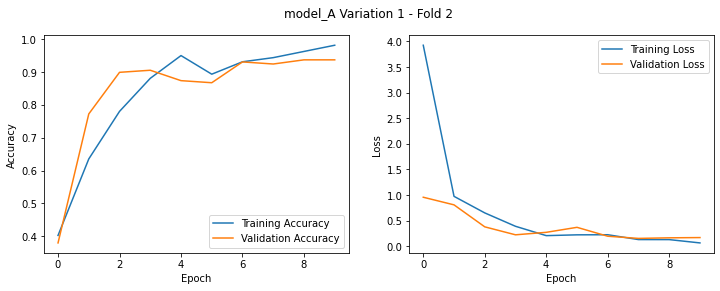

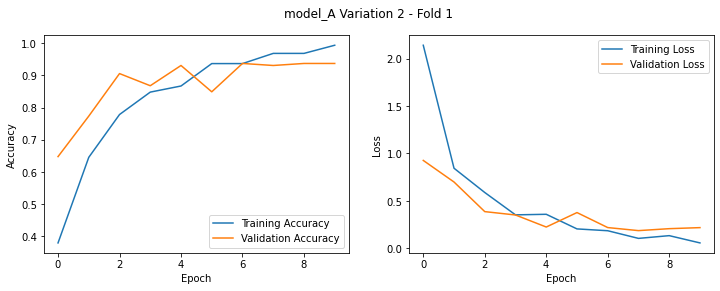

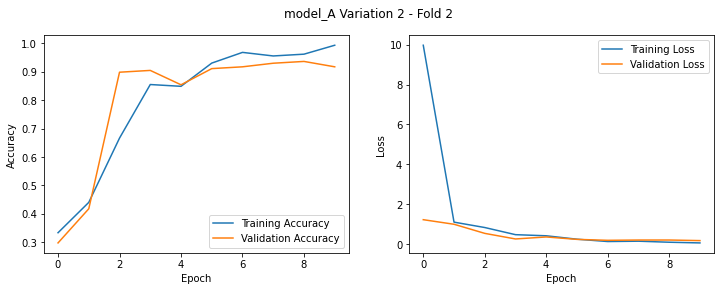

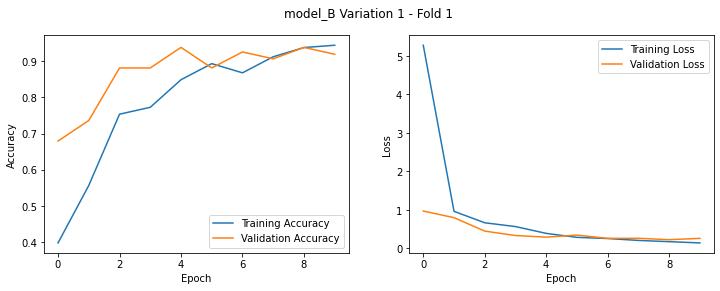

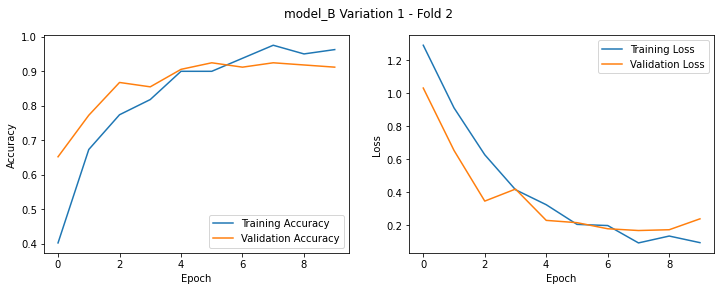

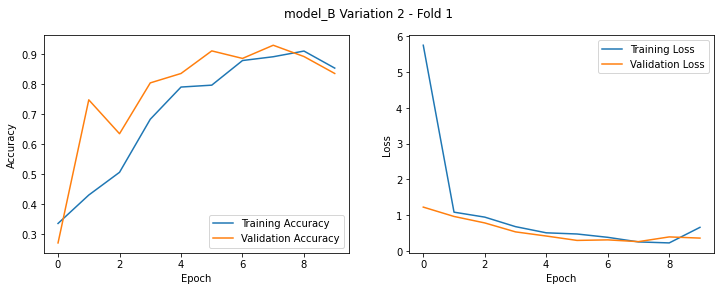

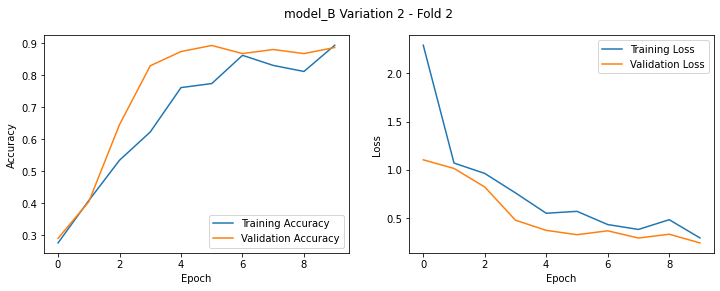

In [76]:
import matplotlib.pyplot as plt

# If this is true, it runs the slow version
run_slow = False

# Function to plot the training and validation accuracy and loss
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Train and evaluate all model variations. Removed the first variation for now
model_variations = [(model_A, 1), (model_A, 2), (model_B, 1), (model_B,2)]
histories = []
models = []

for train_index, test_index in kf.split(X, y):
    print("Fold Number: ", len(histories) + 1)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    sub_histories = []
    sub_models = []
    for model_func, variation in model_variations:
        model = model_func(variation)
        history, model = train_and_evaluate_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=20 if run_slow else 10)
        sub_histories.append(history)
        sub_models.append(model)

    histories.append(sub_histories)
    models.append(sub_models)

# Visualize the performance of all model variations
for idx, (model_func, variation) in enumerate(model_variations):
    title = f"{model_func.__name__} Variation {variation}"
    for i in range(len(histories)):
        plot_history(histories[i][idx], title=f"{title} - Fold {i+1}")


In [93]:
# Print out the accuracy of the model
for idx, (model_func, variation) in enumerate(model_variations):
    print(f"{model_func.__name__} Variation {variation}")
    for i in range(len(histories)):
        print(f"Fold {i+1}: {histories[i][idx].history['val_accuracy'][-1]}")
    print()

model_A Variation 1
Fold 1: 0.9496855139732361
Fold 2: 0.9367088675498962

model_A Variation 2
Fold 1: 0.9371069073677063
Fold 2: 0.9177215099334717

model_B Variation 1
Fold 1: 0.9182389974594116
Fold 2: 0.9113923907279968

model_B Variation 2
Fold 1: 0.8364779949188232
Fold 2: 0.8860759735107422



### Compare the results

In [78]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(model, X, y_true):
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    cm = confusion_matrix(y_true_labels, y_pred)
    return cm

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(cm, display_labels, title):
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()


In [94]:
print(len(histories))

2


5/5 [==============================] - 2s 370ms/step


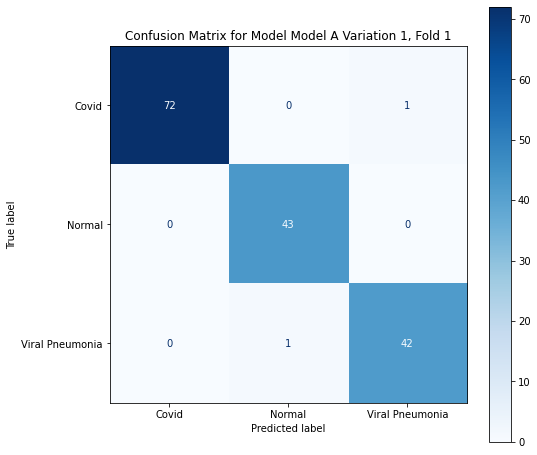

5/5 [==============================] - 2s 374ms/step


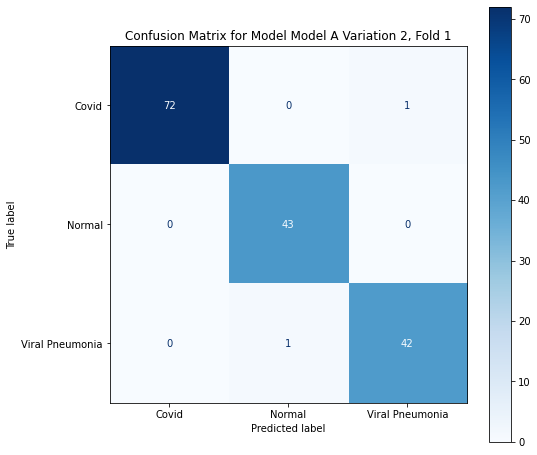

5/5 [==============================] - 2s 355ms/step


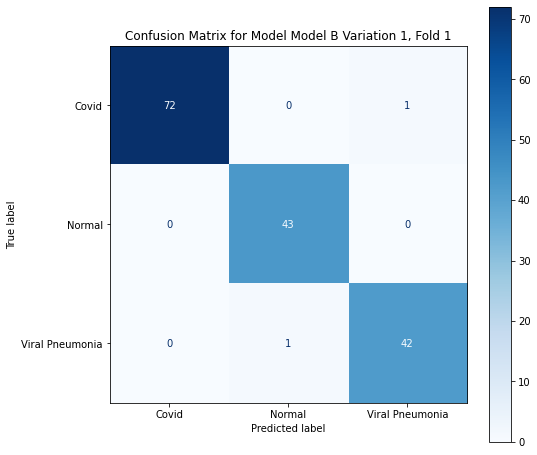

5/5 [==============================] - 2s 354ms/step


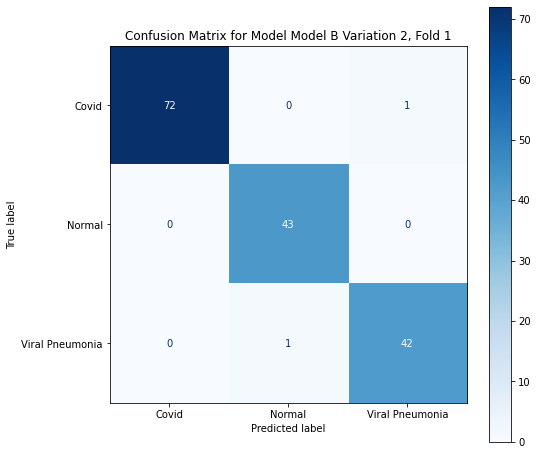

5/5 [==============================] - 2s 358ms/step


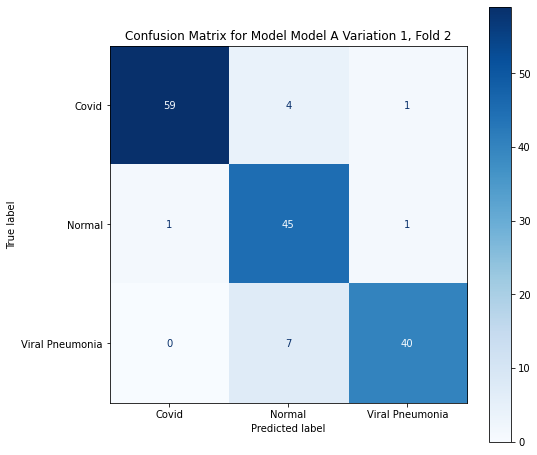

5/5 [==============================] - 2s 364ms/step


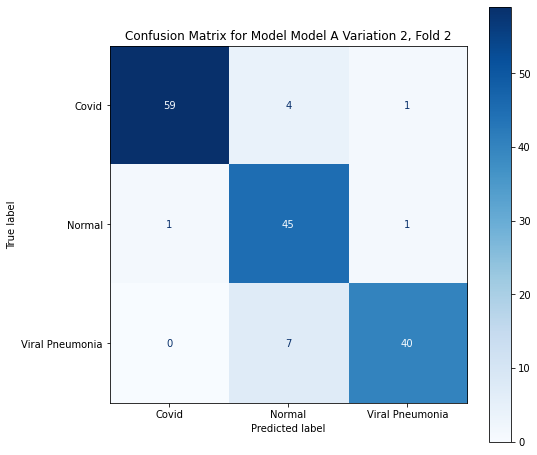

5/5 [==============================] - 2s 355ms/step


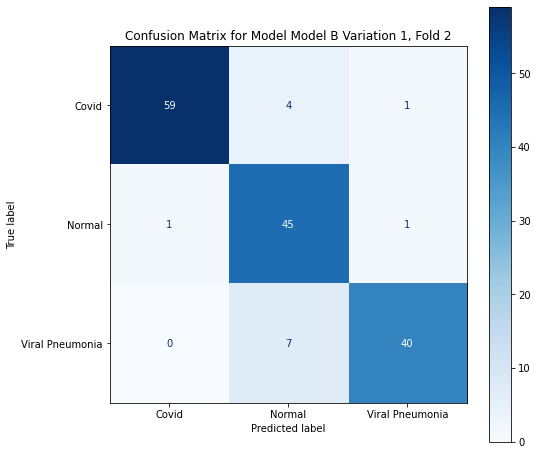

5/5 [==============================] - 2s 355ms/step


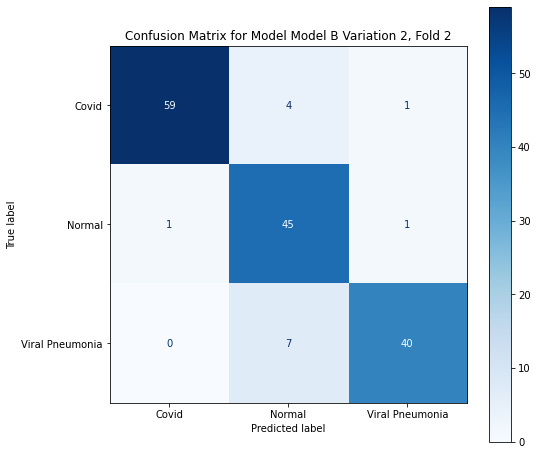

In [95]:
# Compare all the models
y_labels = np.argmax(y, axis=1)

'''
[
    # On the set one
    [model_A(1), model_A(2), model_B(1), model_B(2)],

    # On the set two

]
'''
fold_index = 0
for train_index, test_index in kf.split(X, y):
    model_index = 0
    # Loop through all the models in that fold
    for model in models[fold_index]:
        # Get the test set for this fold
        X_test = X[test_index]
        y_test = y[test_index]

        # Compute the confusion matrix for this fold
        cm = get_confusion_matrix(models[i][j], X_test, y_test)

        # Set the title of the plot
        mod_name = ""
        if model_index == 0:
            mod_name = "Model A Variation 1"
        elif model_index == 1:
            mod_name = "Model A Variation 2"
        elif model_index == 2:
            mod_name = "Model B Variation 1"
        else:
            mod_name = "Model B Variation 2"

        title = f"Confusion Matrix for Model {mod_name}, Fold {fold_index}"
        plot_confusion_matrix(cm, display_labels=encoder.classes_, title=title)
        model_index+= 1

    fold_index += 1

> [1.5 points] Visualize the final results of the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models.  

### Comparing the models

#### Model A Variation 1
* This model used 2 CONV2D Layers, and had 32 and 64 filters
* The model had a training accuracy of 0.9497 for the first fold and an accuracy of 0.9367 for the second fold
* Now, when looking at the convolution matrix, we can see that this variation actually has a few(4) false negatives for Covid, and only one false positive. We would want to minimize the false negatives, so this model is not the best.

### Model A Variation 2
* This model used 2 CONV2D Layers, and had 64 and 128 filters
* The model had a training accuracy of 0.9371 for the first fold and an accuracy of 0.9177 for the second fold
* This model suffers from the same problems as the first variation, but suffers from some extra false negatives in terms of Pneumonia.

### Model B Variation 1
* This model used 4 CONV2D Layers, and had 32 and 64 filters
* The model had a training accuracy of 0.9182 for the first fold and an accuracy of 0.9114 for the second fold
* This model has similar problems with the Model A variation 2, with the same false negatives, but with a few more false positives.

### Model B Variation 2
* This model used 2 CONV2D Layers, and had 64 and 128 filters
* The model had a training accuracy of 0.8365 for the first fold and an accuracy of 0.8861 for the second fold
* This model was just the worst in pretty much every way. I believe it must have been overfitting because of all the filters and layers.

### Conclusion
* The best model was Model A Variation 1, because it had the least amount of false negatives, and the most amount of true positives. This is the best model because we want to minimize the amount of false negatives, because we want to make sure that we are not telling people that they don't have COVID when they actually do.

> [1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

# Exceptional Work (1 points total)
> You have free reign to provide additional analyses. 
> One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 